# Titanic Data Analysis

## The Problem
**On April 15, 1912**, the Titanic sank after colliding with an iceberg, killing **1502 out of 2224** passengers and crew. Predicting which passengers lived and which died is a classic problem in data science. The classic dataset on Titanic passengers includes **12 variables**:

1. PassengerId
2. Survival
3. Pclass
4. Name
5. Sex
6. Age
7. SibSp
8. Parch
9. Ticket
10. Fare
11. Cabin
12. Embarked

The task is to predict the `Survived` variable using the other ten variables.

We begin by loading the data for the 'titanic' competition and installing the libraries we will need for our analysis, including pandas, scikit-learn, xgboost, seaborn, matplotlib, and numpy. To install these libraries, use `pip install pandas scikit-learn matplotlib xgboost seaborn numpy`

In [864]:
import xgboost as xgb
from scipy.stats import randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from typing import Literal
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import warnings

# Filter Future Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Try to import from kaggle/input/titanic/, otherwise create it and download the data
train = pd.read_csv(filepath_or_buffer='/kaggle/input/titanic/train.csv')
test = pd.read_csv(filepath_or_buffer='/kaggle/input/titanic/test.csv')

Note that the data is pre-split into train and test sets by Kaggle. However, in order to get an accurate estimate of the performance of our model, we will further split the training data into `pretrain` and `validation` sets with scikit-learn's `train_test_split` function. We'll put 30% of our training data into the `validation` set, while keeping the other 70% for pretraining.

In [865]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed=seed)
random.seed(a=seed)

# Split the data
pretrain, validation = train_test_split(train, test_size=0.3, random_state=seed)

## Variables

Our next task is to grok the training dataset to see what variables are available to us. Useful functions for this include:

- `df.shape()`, which gives us the number of rows and columns in the DataFrame
- `df.columns()`, which gives us the names of the columns
- `df.head()`, which gives us the first five rows of the DataFrame, or `df.tail()`, which gives us the last five rows of the DataFrame
- `df.sample(n)` or `df.sample(frac)`, which gives us a random sample of `n` rows or `frac` fraction of the rows, respectively
- `df.info()`, which gives us the number of non-null entries in each column, as well as the data type of each column
- `df.describe()`, which gives us summary statistics for each column
- `df.value_counts()`, which gives us the number of occurrences of each value in a column
- `df.unique()`, which gives us the unique values in a column

For example, we can compare the shapes of our train and test sets to verify that they have the same columns and similar distributions of missing values:

In [866]:
# Get column names and non-null values
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

Actually, we notice right away that the test set is missing one value for Fare, whereas the train set is missing no values for Fare. We'll have to impute the missing value later. We also notice that some Age values and most Cabin values are missing for both datasets.

We can also check how many unique values are in each column, which tells us which variables are categorical (with few unique values) and which are continuous (with many unique values):

In [867]:
# Count unique values for each int64 or object column
for column in pretrain.select_dtypes(include=['int64', 'object']).columns:
    print(column, pretrain[column].nunique())

PassengerId 623
Survived 2
Pclass 3
Name 623
Sex 2
SibSp 7
Parch 7
Ticket 495
Cabin 106
Embarked 3


And we can get counts for each unique value in the categorical columns:

In [868]:
# Count occurrences of each unique value in columns with only a few unique values
for column in pretrain.select_dtypes(include=['int64', 'object']).columns:
    if pretrain[column].nunique() < 10:
        print(pretrain[column].value_counts())

Survived
0    392
1    231
Name: count, dtype: int64
Pclass
3    352
1    139
2    132
Name: count, dtype: int64
Sex
male      410
female    213
Name: count, dtype: int64
SibSp
0    418
1    147
2     21
4     14
3     11
8      7
5      5
Name: count, dtype: int64
Parch
0    471
1     85
2     57
4      3
3      3
5      3
6      1
Name: count, dtype: int64
Embarked
S    457
C    110
Q     55
Name: count, dtype: int64


And, for the numerical columns, we can get summary statistics about the distribution of values:

In [869]:
# Use describe to statistically summarize float64 columns
pretrain.select_dtypes(include=['float64']).describe()

,Age,Fare
count,499.000000,623.000000
mean,29.256353,31.840730
std,14.558567,51.027372
min,0.420000,0.000000
25%,20.000000,7.925000
50%,28.000000,14.454200
75%,38.000000,30.750000
max,80.000000,512.329200



Based on our examination of the data (and Kaggle-provided [metadata](https://www.kaggle.com/c/titanic/data) about what the various variables represent), we can make the following observations:

1. **Age**: Most ages are round numbers, but some are fractional because they are either estimated or less than 1. There are many missing values. Ages range from >1 to 80, with a mean around 30.

2. **SibSp**: `SibSp`, short for sibling-spouse, indicates whether the passenger had a sibling or spouse aboard the Titanic. Sibling is defined as a brother, sister, stepbrother, or stepsister. Spouse is defined as a husband or wife (mistresses and fiancés are ignored). This is an ordinal integer feature with the following possible values: 0, 1, 2, 3, 4, 5, 6, 7, and 8. The feature corresponds to the total number of siblings and spouses aboard the Titanic for each passenger. Most passengers had 0.

3. **Parch**: `Parch`, short for parent-child, indicates whether the passenger had a parent or child aboard the Titanic. A parent is defined as a mother or father. A child is defined as a daughter, son, stepdaughter, or stepson. Children that traveled only with a nanny were ignored. This is an ordinal integer feature with the following possible values: 0, 1, 2, 3, 4, 5, and 6. The feature corresponds to the total number of parents and children aboard the Titanic for each passenger. Most passengers had 0.

4. **Pclass**: `Pclass` is a proxy for socio-economic status (SES). This is an ordinal integer feature with the following possible values: 1, 2, and 3. The feature corresponds to the ticket class of each passenger. A value of 1 corresponds to upper class, 2 corresponds to middle class, and 3 corresponds to lower class. Most passengers were in upper class.

4. **Embarked**: `Embarked` is a nominal categorical feature that has the following possible values: C, Q, and S. These correspond to the ports of embarkation, which are Cherbourg, Queenstown, and Southampton, respectively. Most passengers embarked at Southampton. There are a few missing values.
 
5. **Name**: `Name` is a nominal categorical feature that contains the names of each passenger.

6. **Sex**: `Sex` is a nominal categorical feature with the possible values M and F. Most passengers were male.
 
7. **Ticket**: `Ticket` is a nominal alphanumeric feature that contains the ticket number for each passenger.

8. **Cabin**: `Cabin` is a nominal alphanumeric feature that contains the cabin number for each passenger. Some passengers shared cabins, so this feature is not unique to each passenger. Most values are missing.

9.  **Fare**: `Fare` is a continuous float feature that contains the value each passenger paid for their ticket in British pounds. Fares ranged from 0 to around 512 pounds. The mean fare was around 32 pounds.

10. **PassengerId**: `PassengerId` is a nominal integer feature that contains a unique ID number for each passenger.

11. **Survived**: `Survived` is a binary categorical feature with the possible values 0 and 1. A value of 1 indicates that the passenger survived, and a value of 0 indicates that the passenger died.

## Hypotheses

We might expect Age, Sex, Pclass, and Fare to have strong effects on survival, given the social norms of the early 20th century. Passengers with large families might also have received deferential treatment, so SibSp and Parch are likely relevant. These are the most salient variables.

Embarked and Name could perhaps be used in feature engineering to infer additional relevant information about the passenger's social class or ethnicity, though we would expect the information gain to be small. The most relevant information about social class is likely already captured by Pclass.

Ticket number might indicate something about when the ticket was booked, but we would not really expect this to affect survival outcomes. Cabin number could perhaps be used in feature engineering for social network analysis, but we would not expect it to have a large effect on survival. PassengerId is a unique identifier for each passenger, so it should have no effect on survival. These are probably the least salient variables.

## Data Exploration and Visualization

We've learned some basic information about the data, but we can learn more by visualizing the data. We'll use the `matplotlib` and `seaborn` libraries for this. (We'll need to `pip install matplotlib` and `pip install seaborn` before running the following code.)

In [870]:
# Display matplotlib plots inside Jupyter Notebook rather than in a new window
%matplotlib inline

# Set style for seaborn plots
sns.set(style='white', context='notebook', palette='deep')

We'll begin by investigating the distributions of each of the variables. We'll use histograms for the continuous variables, and bar charts for the categorical variables.

<Figure size 640x480 with 0 Axes>

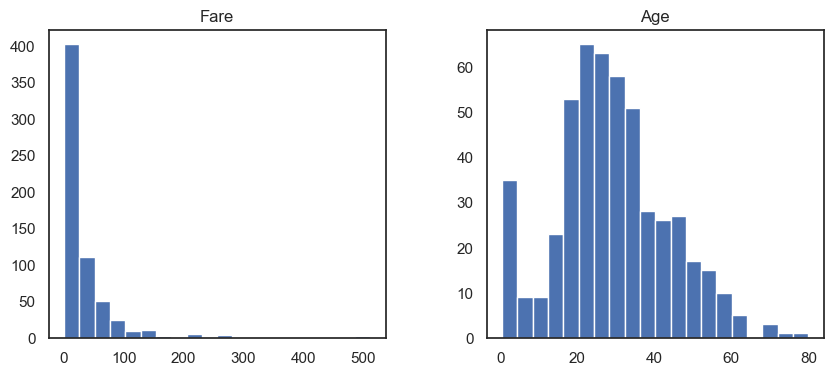

<Figure size 640x480 with 0 Axes>

In [871]:
# Display histograms for the two continuous variables, Fare and Age
pretrain[['Fare', 'Age']].hist(figsize=(10, 4), bins=20, grid=False)
plt.figure()

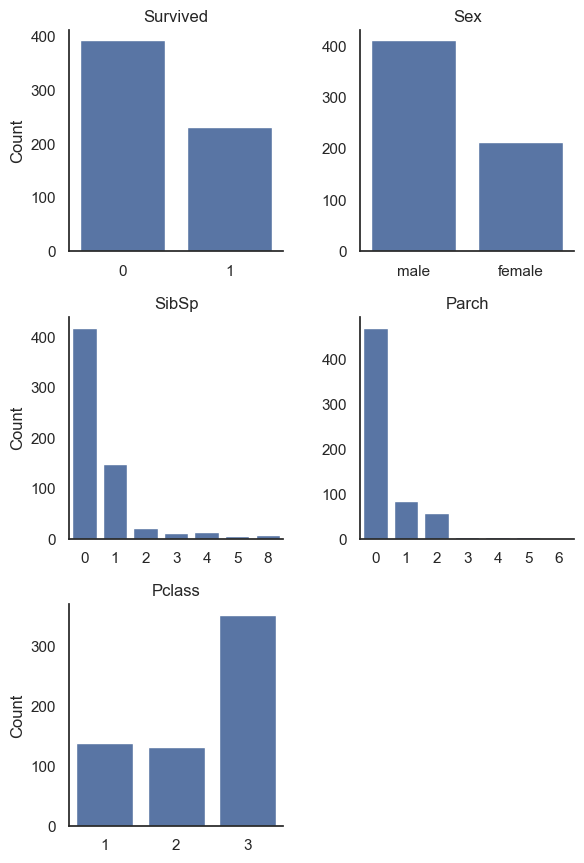

In [872]:
# Melt the data to long-form
melted_data = pd.melt(frame=pretrain, value_vars=['Survived', 'Sex', 'SibSp', 'Parch', 'Pclass'])

# Function to handle plotting within FacetGrid
def custom_countplot(x, **kwargs):
    sns.countplot(x=x, **kwargs)

# Create the FacetGrid
g = sns.FacetGrid(data=melted_data, col='variable', col_wrap=2, sharex=False, sharey=False)
g = g.map(custom_countplot, 'value')

# Adjust the axis labels and titles
g.set_axis_labels(x_var="", y_var="Count")
g.set_titles(template="{col_name}")

# Show the plots
plt.show()

We also want to understand the relationships between variables. We can do this at a glance with a table of correlation coefficients, although this will only tell us about linear relationships. In order to generate a table of correlation coefficients, we need to convert the categorical 'Sex' variable to a binary numerical variables by one-hot encoding.

In [873]:
# One-hot encode the Sex column as binary Sex_male
for df in [pretrain, validation, train, test]:
    imputed_df = pd.get_dummies(data=df, columns=['Sex'], drop_first=True)
    df['Sex_male'] = imputed_df['Sex_male']

# Drop the remaining categorical columns and compute the correlation matrix
pretrain.drop(columns=['Name', 'Sex', 'Embarked', 'PassengerId', 'Cabin', 'Ticket']).corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male
Survived,1.000000,-0.312233,-0.078538,-0.049527,0.076756,0.239060,-0.532598
Pclass,-0.312233,1.000000,-0.355026,0.097146,0.030596,-0.529208,0.127310
Age,-0.078538,-0.355026,1.000000,-0.319626,-0.190836,0.094097,0.099275
SibSp,-0.049527,0.097146,-0.319626,1.000000,0.440442,0.154613,-0.092611
Parch,0.076756,0.030596,-0.190836,0.440442,1.000000,0.208619,-0.258301
Fare,0.239060,-0.529208,0.094097,0.154613,0.208619,1.000000,-0.167973
Sex_male,-0.532598,0.127310,0.099275,-0.092611,-0.258301,-0.167973,1.000000


Here we see a strong relationship between 'SibSp' and 'Parch', which makes sense, since these are both measures of family size. The strong correlation we observe between 'Pclass' and 'Fare' also makes sense, given that upper class tickets tend to be more expensive. Women on the Titanic were more likely to have parent-child or sibling-spouse relationships, while men were more likely to have paid a higher fare.

Of greater relevance for our forecasting task, we observe a strong (negative) relationship between 'Survived' and 'Sex_male', and weaker relationships between 'Survived' and 'Pclass' and 'Fare'. Surprisingly, the relationship of 'Survived' to 'Age' and 'Parch' is quite weak.

Since 'Embarked' is categorical and not ordinal, we can't use a correlation coefficient to measure its relationships to other variables. Instead, we can group the data by 'Embarked' and compute the means of other variables for each group:

In [874]:
# Group by Embarked and summarize survival rate
pretrain.drop(columns=['Name', 'PassengerId', 'Cabin', 'Ticket', 'Sex']).groupby(by='Embarked').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male
Embarked,,,,,,,
C,0.563636,1.954545,29.126977,0.363636,0.327273,55.958791,0.572727
Q,0.381818,2.927273,24.750000,0.545455,0.127273,13.060985,0.563636
S,0.321663,2.367615,29.492347,0.632385,0.433260,28.190270,0.691466


Surprisingly, we see a significantly higher survival rate for embarkations from Cherbourg. This is probably due to confounding variables, such as the fact that Cherbourg passengers were more likely to be female and upper class and to have paid a higher fare. The survival rate for Queenstown is also higher than for Southampton even though Queenstown passengers were on average lower class and paid the lowest fares. This might be related to our sex variable, as Queenstown passengers were the most female. We can investigate this further by grouping the data by 'Embarked' and 'Pclass' and computing the mean 'Sex_male', 'Fare', and 'Survived' for each group:

In [875]:
# Group by Embarked and Pclass and summarize Sex, Fare, and Survival rate by mean
pretrain[['Embarked', 'Pclass', 'Sex_male', 'Fare', 'Survived']].groupby(by=['Embarked', 'Pclass']).mean()

Sex_male        Fare  Survived
Embarked Pclass                                
C        1       0.500000  105.373750  0.720000
         2       0.533333   26.033060  0.600000
         3       0.666667   11.028524  0.377778
Q        1       1.000000   90.000000  0.000000
         2       0.000000   12.350000  1.000000
         3       0.576923   11.608735  0.365385
S        1       0.597701   75.966571  0.528736
         2       0.652174   20.140652  0.452174
         3       0.741176   15.520340  0.192157

Sure enough, we find that departures from Cherbourg and Queenstown exhibit generally higher survival rates than departures from Southampton across all three social classes, but that sex and fare may explain a lot of the difference.

Note that while the survival rates for first- and second-class passengers for Queenstown violate the pattern a bit, that's because there are only a few passengers in these groups. We can get more insight into the size of each group by using a contingency table, as shown below.

In [876]:
# Create a contingency table indexing Survived against Pclass and Embarked
contingency_table = pd.crosstab(index=pretrain['Survived'], columns=[pretrain['Pclass'], pretrain['Embarked']])
print(contingency_table)

Pclass     1         2          3         
Embarked   C  Q   S  C  Q   S   C   Q    S
Survived                                  
0         14  1  41  6  0  63  28  33  206
1         36  0  46  9  2  52  17  19   49


In general, we've found some evidence to support our hypothesis that 'Embarked' is independent of survival, but not enough to drop it from our model.

We've noticed some interesting linear relationships, but what about non-linear ones? For instance, I suspect that young children might have received preferential places in lifeboats, while there might have been less age-based preferential treatment among adults. We can visualize this with a violinplot:

<Axes: xlabel='Survived', ylabel='Age'>

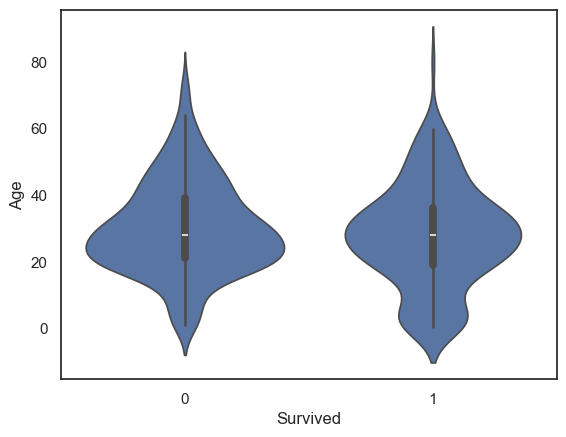

In [877]:
# violinplot of Age grouped by Survived
sns.violinplot(data=pretrain,x="Survived", y="Age")

Sure enough, we find that the non-survival and survival groups had similar means and similar distributions. However, there are a few non-linear differences between them. As we hypothesized, young children under ten survived at higher rates. This is a non-linear relationship that we might want to capture in our model. However, we also observe a high mortality rate for young adults in their early twenties, while adults in the survival group actually skewed a bit older. That might be deference shown to the elderly, or it might be a function of lower-class passengers skewing younger, as we can observe with a violinplot of 'Pclass' against 'Age':

<Axes: xlabel='Pclass', ylabel='Age'>

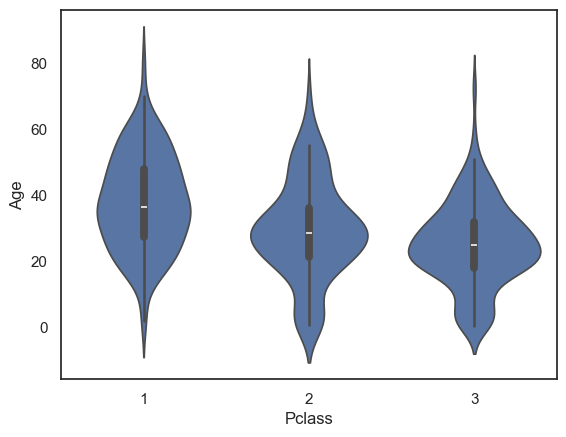

In [878]:
sns.violinplot(x='Pclass',y='Age',data=pretrain)

Since we now know that young children survived preferentially, let's investigate whether their parents were given places in the lifeboats with them. We can do this by filtering the data for passengers over 18 years old and plotting 'Parch' against 'Survived':

<Axes: xlabel='Survived', ylabel='Parch'>

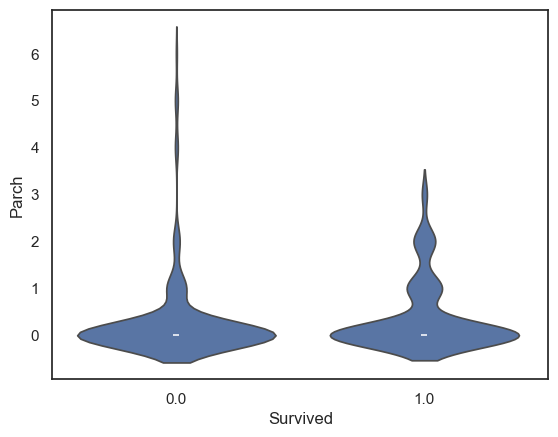

In [879]:
sns.violinplot(x='Survived',y='Parch',data=pretrain.where(cond=pretrain['Age'] > 18))

Interestingly, a few parents with very large families did not survive (perhaps because they had low SES?). However, we can clearly see better survival for parents with 1–3 children, which is consistent with our hypothesis that some parents may have received preferential treatment along with their children.

As a feature engineering exercise, let's also take a look at the 'Name', 'Cabin', and 'Ticket' variables to see what information we might be able to extract from these.

In [880]:
# Inspect head of train for Name, Cabin, and Ticket columns
pretrain[['Name', 'Cabin', 'Ticket']].head(n=15)

,Name,Cabin,Ticket
445,"Dodge, Master. Washington",A34,33638
650,"Mitkoff, Mr. Mito",NaN,349221
172,"Johnson, Miss. Eleanor Ileen",NaN,347742
450,"West, Mr. Edwy Arthur",NaN,C.A. 34651
314,"Hart, Mr. Benjamin",NaN,F.C.C. 13529
332,"Graham, Mr. George Edward",C91,PC 17582
801,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",NaN,C.A. 31921
90,"Christmann, Mr. Emil",NaN,343276
834,"Allum, Mr. Owen George",NaN,2223
181,"Pernot, Mr. Rene",NaN,SC/PARIS 2131


Several things to note here. First, many of the ticket numbers have prefixes that may or may not be meaningful for our prediction problem. We could also probably look for shared cabins or tickets to identify passengers who were traveling together. Ticket numbers are alphanumeric, with the letter perhaps indicating a level, and the number indicating the cabin number. These could perhaps be used as a measure of physical proximity to other passengers, which might be relevant for survival. As for the names, they generally include titles, which could be extracted as an indicator of age or social status, and they also parenthetically link wives to husbands, which we could use to infer family relationships. Such feature engineering might be helpful for improving our model or imputing missing data.

## Feature Engineering

Let's experiment with some feature engineering. For this step, we'll need to make sure we do the same feature engineering for all our data, but we'll only actually work with pretrain for feature design and evaluation purposes. (This is probably an overly conservative approach to preventing information leakage, but it's better to be safe than sorry.)

For starters, we'll extract the title from each passenger's name, the deck from each passenger's cabin number, and the prefix from each passenger's ticket.

In [881]:
for df in [pretrain, validation, train, test]:
    # Extract the first character of Cabin and save as Deck
    df['Deck'] = df['Cabin'].str[0]

# Get value counts for Deck
pretrain['Deck'].value_counts(dropna=True)

Deck
C    41
B    32
E    23
D    18
F    11
A    10
G     3
T     1
Name: count, dtype: int64

The Deck feature is promising, though the many missing values may reduce its usefulness. The Titanic had decks A-G, with A being the uppermost. I'd like to try making this an ordinal variable, since the decks can be ordered top to bottom. Cabin T, with only one passenger, was apparently on the boat deck, so we'll make that Deck 1. After concluding this mapping, let's see if our ordinal variable has any relationship to other ordinal variables:

In [882]:
# Map Deck to dictionary
deck_map = {
    'T' : 1,
    'A' : 2,
    'B' : 3,
    'C' : 4,
    'D' : 5,
    'E' : 6,
    'F' : 7,
    'G' : 8
}

for df in [pretrain, validation, train, test]:
    # Map deck_map to Deck in train and test
    df['Deck'] = df['Deck'].map(arg=deck_map).astype(dtype='Int64')

# Group by Deck and summarize mean Fare and Pclass
print(pretrain[['Deck', 'Fare', 'Pclass']].groupby(by='Deck').mean())

            Fare    Pclass
Deck                      
1      35.500000  1.000000
2      40.557910  1.000000
3     105.926566  1.000000
4     105.619407  1.000000
5      57.470150  1.111111
6      43.060509  1.391304
7      18.778027  2.454545
8      12.541667  3.000000


If our ordinal ranking is correct, we should see a strong negative correlation between Deck and Pclass, and a strong negative correlation between Deck and Fare. We do indeed see a strong relationship with Pclass, with the first four decks exclusive to upper-class people. However, we see a weaker relationship with Fare. The luxury berths may have been located on the third and fourth decks, with the top decks consisting of more standard cabins. It' i's tempting to rearrange the deck order to reflect this, but we should be careful about introducing our own biases into the model. We'll leave the deck order as is.

It's possible that we can impute missing values for Deck by assuming that passengers who shared the same ticket number stayed on the same deck. Let's see if this is the case:

In [883]:
# Group passengers who shared a Ticket and summarize unique values for Deck
ticket_decks = pretrain[['Ticket', 'Deck']].groupby(by='Ticket').nunique()

# Sort by number of unique Deck values descending and print the rows
print(ticket_decks.sort_values(by='Deck', ascending=False).head(n=10))

        Deck
Ticket      
110152     1
36947      1
35281      1
35273      1
348124     1
348123     1
348121     1
110413     1
347054     1
34218      1


This looks promising. We can use this information to impute missing values for Deck.

In [884]:
print(pretrain['Deck'].isna().sum())

# Impute validation only with info from pretrain and test only with info from train
for trn, tst in [(pretrain, validation), (train, test)]:
    # Initialize an empty dictionary
    ticket_deck_map = {}
    
    # Iterate over the train dataset and update the dictionary only if the Ticket is not already a key in it
    for ticket, deck in zip(trn['Ticket'], trn['Deck']):
        if pd.notnull(deck) and ticket not in ticket_deck_map:
            ticket_deck_map[ticket] = deck
            
    # Use ticket_deck_map to impute missing Deck in train and test
    trn['Deck'] = trn['Ticket'].map(arg=ticket_deck_map).astype(dtype='Int64')
    tst['Deck'] = tst['Ticket'].map(arg=ticket_deck_map).astype(dtype='Int64')

print(pretrain['Deck'].isna().sum())

484
480


Unfortunately, this reduces the number of missing values only very modestly.

Recall that we had one missing Fare value. The strong relationship between Deck and Fare suggests that we may be able to impute the missing Fare value based on the Deck value. Unfortunately, investigating the data reveals that we don't have a Deck value for the row with the missing Fare.

In [885]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male,Deck
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,True,<NA>


Let's look next at ticket prefixes. For starters, we extract the prefixes and count the unique values:

In [886]:
# If no space exists in Ticket column, TicketPrefix is 'NoPrefix'
# Else, extract anything before a space in the Ticket column and save as TicketPrefix
for df in [pretrain, validation, train, test]:
    df['TicketPrefix'] = df['Ticket'].apply(func=lambda x: 'NoPrefix' if ' ' not in x else x.split(' ')[0])

    # Standardize TicketPrefix
    df['TicketPrefix'] = df['TicketPrefix'].str.replace(pat='.', repl='')
    df['TicketPrefix'] = df['TicketPrefix'].str.upper()
    df['TicketPrefix'] = df['TicketPrefix'].str.replace(pat='STON', repl='SOTON')
    df['TicketPrefix'] = df['TicketPrefix'].str.replace(pat='A/4', repl='A4')
    df['TicketPrefix'] = df['TicketPrefix'].str.replace(pat='A/5', repl='A5')
    df['TicketPrefix'] = df['TicketPrefix'].str.replace(pat='WE/P', repl='WEP')

# Get value counts for TicketPrefix
pretrain['TicketPrefix'].value_counts(dropna=True)

TicketPrefix
NOPREFIX    463
PC           35
CA           35
A5           16
SOTON/OQ     10
SC/PARIS      9
SOTON/O       9
W/C           7
SOTON/O2      6
A4            5
C             4
FCC           3
SOC           3
WEP           3
P/PP          2
SO/PP         2
SW/PP         2
PP            2
SC/AH         1
FA            1
SC/A4         1
SOP           1
FC            1
SC            1
CA/SOTON      1
Name: count, dtype: int64

Even after we standardize this feature a bit, it's kind of a mess. Many of the prefixes contain two values separated by slashes. We suspect that the prefixes may indicate something about origin and destination, since we recognize "PARIS" and "SOTON" as locations. Alphanumeric combinations might indicate something about ticket class. But it's mostly not clear how to even group different prefixes together, let alone how to interpret them. Grouping the various features by TicketPrefix and computing their means by group can offer some insight. (Before proceeding, we will one-hot encode the 'Embarked' feature, creating an indicator variable to indicate the locations of the two missing values, which `get_dummies` automatically imputes as zero. We will re-impute these values more intelligently later.)

In [887]:
for df in [pretrain, validation, train, test]:
    encoded_df = pd.get_dummies(data=df, columns=['Embarked'], drop_first=True, dummy_na=True)
    df['Embarked_Q'] = encoded_df['Embarked_Q']
    df['Embarked_S'] = encoded_df['Embarked_S']
    df['Embarked_nan'] = encoded_df['Embarked_nan']

pretrain[['TicketPrefix', 'Pclass', 'Sex_male', 'Fare', 'Survived', 'Embarked_Q', 'Embarked_S']].groupby(by='TicketPrefix').mean()

,Pclass,Sex_male,Fare,Survived,Embarked_Q,Embarked_S
TicketPrefix,,,,,,
A4,3.000000,1.000000,14.440000,0.000000,0.000000,1.000000
A5,3.000000,0.875000,9.692706,0.062500,0.062500,0.937500
C,3.000000,0.750000,10.841675,0.500000,0.000000,1.000000
CA,2.600000,0.600000,34.588571,0.371429,0.000000,1.000000
CA/SOTON,2.000000,1.000000,10.500000,0.000000,0.000000,1.000000
FA,3.000000,1.000000,7.312500,0.000000,0.000000,1.000000
FC,1.000000,1.000000,52.000000,0.000000,0.000000,1.000000
FCC,2.000000,0.333333,21.000000,0.666667,0.000000,1.000000
NOPREFIX,2.371490,0.658747,27.056415,0.360691,0.116631,0.730022


Here we see that the prefixes are highly correlated with 'Embarked'. The 'SC', 'PARIS', and 'P/PP' prefixes exclusively departed from Cherbourg, while most of the other prefixes, including 'CA', exclusively departed from Southampton. 'PC', 'NOPREFIX', and 'A5' are highly but not perfectly correlated with 'Embarked'. This suggests that much of the information captured by TicketPrefix is already reflected in other variables—especially 'Embarked'—but that there may be some additional information in the prefixes. If nothing else, they will be helpful for imputation of missing 'Embarked' values. We'll bucket the highest-frequency prefixes together, and class the rest as 'OTHER' or 'NOPREFIX'.

In [888]:
# Create one-hot encoded features if TicketPrefix contains CA, PC, A5, A4, SOTON, PARIS, or NOPREFIX
for df in [pretrain, validation, train, test]:
    df['TicketPrefix_NOPREFIX'] = df['TicketPrefix'].apply(lambda x: 1 if 'NOPREFIX' in x else 0)
    df['TicketPrefix_PC'] = df['TicketPrefix'].apply(lambda x: 1 if 'PC' in x else 0)
    df['TicketPrefix_CA'] = df['TicketPrefix'].apply(lambda x: 1 if 'CA' in x else 0)
    df['TicketPrefix_A5'] = df['TicketPrefix'].apply(lambda x: 1 if 'A5' in x else 0)
    df['TicketPrefix_SOTON'] = df['TicketPrefix'].apply(lambda x: 1 if 'SOTON' in x else 0)
    df['TicketPrefix_SC'] = df['TicketPrefix'].apply(lambda x: 1 if 'SC' in x else 0)
    df['TicketPrefix_OTHER'] = df['TicketPrefix'].apply(lambda x: 1 if not ('NOPREFIX' in x or 'PC' in x or 'CA' in x or 'A5' in x or 'SOTON' in x or 'SC' in x) else 0)

# Count sums of one-hot encoded features
print(pretrain[['TicketPrefix_NOPREFIX', 'TicketPrefix_PC', 'TicketPrefix_CA', 'TicketPrefix_A5', 'TicketPrefix_SOTON', 'TicketPrefix_SC', 'TicketPrefix_OTHER']].sum())

TicketPrefix_NOPREFIX    463
TicketPrefix_PC           35
TicketPrefix_CA           36
TicketPrefix_A5           16
TicketPrefix_SOTON        26
TicketPrefix_SC           12
TicketPrefix_OTHER        36
dtype: int64


Finally, let's do a little feature engineering on the Name variable, which contains information about title, passenger name, and spouse's name. We'll try to separate these three elements.

In [889]:
for df in [pretrain, validation, train, test]:
    # Extract phrase that follows ', ' and ends with '.' in Name and save as Title
    df['Title'] = df['Name'].str.split(pat=', ', expand=True)[1].str.split(pat='.', expand=True)[0]

    # Delete pattern starting with ' ' and ending with '.' from Name
    df['Name'] = df['Name'].str.replace(pat=' .*\.', repl='', regex=True)

    # Extract text inside parentheses and save as PassengerName only for rows with Title=='Mrs'
    df.loc[df['Title'] == 'Mrs', 'PassengerName'] = df.loc[df['Title'] == 'Mrs', 'Name'].str.extract(pat='\\((.*)\\)').iloc[:, 0]

    # Extract text before ' (' to SpouseName only for rows with Title=='Mrs'
    df.loc[df['Title'] == 'Mrs', 'SpouseName'] = df.loc[df['Title'] == 'Mrs', 'Name'].str.split(pat=' \\(', expand=True).iloc[:, 0]

    # Set PassengerName to Name for rows with NaN PassengerName
    df['PassengerName'] = df['PassengerName'].fillna(value=df['Name'])

Next, for each train-test split, we'll create a spouse_map based on train and use it to impute missing values for SpouseName in both train and test.

In [890]:
# Map all non-NA values of SpouseName to corresponding PassengerName
spouse_map = {row.SpouseName: row.PassengerName for _, row in pd.concat([train, test])[['SpouseName', 'PassengerName']].dropna().iterrows()}
reversed_spouse_map = {value: key for key, value in spouse_map.items()}
spouse_map.update(reversed_spouse_map)

# Construct SpouseName feature
for trn, tst in [(pretrain, validation), (train, test)]:
    # Match SpouseName key in spouse_map to PassengerName in all_data and save corresponding value as SpouseName
    trn['SpouseName'] = trn['PassengerName'].map(arg=spouse_map)
    tst['SpouseName'] = tst['PassengerName'].map(arg=spouse_map)

We can also create a SpouseAge feature, which might help with imputing some values of Age.

In [891]:
# Create age_map of PassengerName to corresponding Age
age_map = {passenger : age for passenger, age in pd.concat([train, test])[['PassengerName', 'Age']].dropna().values}

# Construct SpouseAge feature
for trn, tst in [(pretrain, validation), (train, test)]:
    # Use age_map to get SpouseAge
    trn['SpouseAge'] = trn['SpouseName'].map(arg=age_map)
    tst['SpouseAge'] = tst['SpouseName'].map(arg=age_map)

    # Print number of missing values for Age in rows where SpouseAge is not null
    print("Number of Age values we can impute using SpouseAge:", trn.loc[trn['SpouseAge'].notnull(), 'Age'].isnull().sum())

Number of Age values we can impute using SpouseAge: 1
Number of Age values we can impute using SpouseAge: 6


There are unfortunately only a few cases where this is possible. Let's see if we have better luck using SpouseName to impute missing values for Deck:

In [892]:
# Create deck_map of PassengerName to corresponding Deck
deck_map = {passenger : deck for passenger, deck in pd.concat([train, test])[['PassengerName', 'Deck']].dropna().values}

# Construct SpouseDeck feature
for trn, tst in [(pretrain, validation), (train, test)]:
    # Use deck_map to get SpouseDeck
    trn['SpouseDeck'] = trn['SpouseName'].map(arg=deck_map)
    tst['SpouseDeck'] = tst['SpouseName'].map(arg=deck_map)

    # Print number of missing values for Deck in rows where SpouseDeck is not null
    imputable_values = trn.loc[~trn['SpouseDeck'].isna(), 'Deck'].isna().sum() + tst.loc[~tst['SpouseDeck'].isna(), 'Deck'].isna().sum()
    print("Number of Deck values we can impute with spouse's Deck: " + str(object=imputable_values))

Number of Deck values we can impute with spouse's Deck: 5
Number of Deck values we can impute with spouse's Deck: 1


Unfortunately, there is only one missing Deck value we can impute with information from the spouse. But perhaps we can use the spouse's Fare to impute the missing Fare value:

In [893]:
# Construct SpouseDeck feature
for trn, tst in [(pretrain, validation), (train, test)]:
    # Create deck_map of PassengerName to corresponding Deck
    fare_map = {passenger : fare for passenger, fare in trn[['PassengerName', 'Fare']].dropna().values}

    # Use deck_map to get SpouseDeck
    trn['SpouseFare'] = trn['SpouseName'].map(arg=deck_map)
    tst['SpouseFare'] = tst['SpouseName'].map(arg=deck_map)

    # Print number of missing values for Deck in rows where SpouseDeck is not null
    imputable_values = trn.loc[~trn['SpouseFare'].isna(), 'Fare'].isna().sum() + tst.loc[~tst['SpouseFare'].isna(), 'Fare'].isna().sum()
    print("Number of Fare values we can impute with spouse's Fare: " + str(object=imputable_values))

Number of Fare values we can impute with spouse's Fare: 0
Number of Fare values we can impute with spouse's Fare: 0


Unfortunately not.

Here's where playing with spouse names gets really fun, though. We can construct a SpouseSurvived feature, which might be useful for predicting our target variable.

In [894]:
# Create survived_map of PassengerName to corresponding Survived
survived_map = {passenger : survived for passenger, survived in trn[['PassengerName', 'Survived']].dropna().values}

# Construct SpouseSurvived feature
for trn, tst in [(pretrain, validation), (train, test)]:
    # Use survived_map to get SpouseSurvived
    trn['SpouseSurvived'] = trn['SpouseName'].map(arg=survived_map)
    tst['SpouseSurvived'] = tst['SpouseName'].map(arg=survived_map)

Finally, let's work on our Title feature. Counting the unique values, we find that many have only a few occurrences:

In [895]:
# Get value counts of unique values in Title
print(pretrain['Title'].value_counts(dropna=False))

Title
Mr              368
Miss            125
Mrs              82
Master           31
Rev               4
Dr                4
Col               2
Mlle              2
Capt              1
Mme               1
Ms                1
the Countess      1
Lady              1
Name: count, dtype: int64


Let's try to keep each group larger than 20 observations by binning the lowest-frequency titles. Fortunately, most of these fit naturally into their own category, which we might characterize as being comprised of 'Elite' titles. The exceptions are 'Ms' and 'Mlle', which we'll bin with 'Miss', and 'Mme', which we'll bin with 'Mrs'. Having decided upon 'Mr', 'Miss', 'Mrs', 'Master', and 'Elite', we peek at the rest of the data to see what other titles we need to map to one of these bins, and we find a few:

In [896]:
pd.concat(objs=[pretrain['Title'], validation['Title'], test['Title']]).unique()

array(['Master', 'Mr', 'Miss', 'Mrs', 'Col', 'Mlle', 'Rev', 'Dr', 'Capt',
       'Mme', 'Ms', 'the Countess', 'Lady', 'Don', 'Jonkheer', 'Sir',
       'Major', 'Dona'], dtype=object)

In [897]:
title_mapping = {
    'Capt': 'Elite',
    'Col': 'Elite',
    'Don': 'Elite',
    'Dona': 'Elite',
    'Dr': 'Elite',
    'Jonkheer': 'Elite',
    'Lady': 'Elite',
    'Major': 'Elite',
    'Master': 'Master',
    'Miss': 'Miss',
    'Mlle': 'Miss',
    'Mme': 'Mrs',
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Ms': 'Miss',
    'Rev': 'Elite',
    'Sir': 'Elite',
    'the Countess': 'Elite',
}

for df in [pretrain, validation, train, test]:
    # Replace the titles based on the mapping
    df['Title'] = df['Title'].map(arg=title_mapping)

# Get value counts of unique values in Title
print(pretrain['Title'].value_counts(dropna=False))

Title
Mr        368
Miss      128
Mrs        83
Master     31
Elite      13
Name: count, dtype: int64


This feature can perhaps be used to impute Age and Fare. Let's explore whether it is correlated with either of these variables:

In [898]:
# Group all_data by Title and Pclass and summarize by median Age and Fare
print(pretrain[['Title', 'Pclass', 'Age', 'Fare']].groupby(by=['Title', 'Pclass']).median())

                Age     Fare
Title  Pclass               
Elite  1       48.0  39.6000
       2       51.0  14.0000
Master 1        4.0  81.8583
       2        1.5  26.0000
       3        4.0  29.1250
Miss   1       29.5  99.9625
       2       24.0  13.0000
       3       17.0   9.5875
Mr     1       38.5  50.4958
       2       30.0  13.0000
       3       28.0   7.8958
Mrs    1       39.0  75.2500
       2       31.5  23.0000
       3       30.5  15.9750


There do, indeed, appear to be salient relationships here. 'Master' is evidently a title used for infants and young children. Unmarried women tend to be younger, and married men and women older. The first-class group also tends to be older than second and third. That suggests this feature will be very useful for Age imputation.

As a final exercise, let's try extracting a Surname feature from PassengerName and SpouseName. This might be useful for identifying family relationships.

In [899]:
# Create a new feature Surname
for df in [pretrain, validation, train, test]:
    # If Sex is female and SpouseName is not null and SpouseName has a comma, extract the text before the comma and save as Surname
    condition = (df['Sex'] == 'female') & (df['SpouseName'].notnull()) & (df['SpouseName'].str.contains(pat=',').fillna(False))
    df.loc[condition, 'Surname'] = df.loc[condition, 'SpouseName'].str.split(pat=',', expand=True)[0]
    # If Sex is female and SpouseName is not null and SpouseName doesn't have a comma, split SpouseName on space and extract the last element and save as Surname
    condition = (df['Sex'] == 'female') & (df['SpouseName'].notnull()) & (~df['SpouseName'].str.contains(pat=',').fillna(False))
    df.loc[condition, 'Surname'] = df.loc[condition, 'SpouseName'].str.split(pat=' ').str[-1]
    # If Sex is female and SpouseName is null and PassengerName has a comma, extract the text before the comma and save as Surname
    condition = (df['Sex'] == 'female') & (df['SpouseName'].isnull()) & (df['PassengerName'].str.contains(pat=',').fillna(False))
    df.loc[condition, 'Surname'] = df.loc[condition, 'PassengerName'].str.split(pat=',', expand=True)[0]
    # If Sex is female and SpouseName is null and PassengerName doesn't have a comma, split PassengerName on space and extract the last element and save as Surname
    condition = (df['Sex'] == 'female') & (df['SpouseName'].isnull()) & (~df['PassengerName'].str.contains(pat=',').fillna(False))
    df.loc[condition, 'Surname'] = df.loc[condition, 'PassengerName'].str.split(pat=' ').str[-1]
    # If Sex is male and PassengerName has a comma, extract the text before the comma and save as Surname
    condition = (df['Sex'] == 'male') & (df['PassengerName'].notnull()) & (df['PassengerName'].str.contains(pat=',').fillna(False))
    df.loc[condition, 'Surname'] = df.loc[condition, 'PassengerName'].str.split(pat=',', expand=True)[0]
    # If Sex is male and PassengerName doesn't have a comma, split PassengerName on space and extract the last element and save as Surname
    condition = (df['Sex'] == 'male') & (df['PassengerName'].notnull()) & (~df['PassengerName'].str.contains(pat=',').fillna(False))
    df.loc[condition, 'Surname'] = df.loc[condition, 'PassengerName'].str.split(pat=' ').str[-1]

With our Surname feature, we can construct a 'SurnameCount' and a 'SurnameSurvivalRate', which should be helpful in predicting 'Survived'. Of course, we have to be careful to construct these features without reference to the test set and, for each row, without reference to the target variable for that row.

In [900]:
# Get Surname count_map and survival_map
count_map = pd.concat([train, test]).groupby(by='Surname').size().to_dict()

# Construct SurnameCount and SurnameSurvivalRate feature
for trn, tst in [(pretrain, validation), (train, test)]:
    survival_map = trn.groupby(by='Surname')['Survived'].sum().to_dict()
    
    # Use count_map to get SurnameCount
    trn['SurnameCount'] = trn['Surname'].map(arg=count_map)
    tst['SurnameCount'] = tst['Surname'].map(arg=count_map)

    # Use survived_map to get SurnameSurvivedCount
    trn['SurnameSurvivedCount'] = trn['Surname'].map(arg=survival_map)
    tst['SurnameSurvivedCount'] = tst['Surname'].map(arg=survival_map)

    # For each row, subtract 1 from SurnameCount and Survived from SurnameSurvivedCount
    trn['SurnameCount'] = trn['SurnameCount'] - 1
    trn['SurnameSurvivedCount'] = trn['SurnameSurvivedCount'] - trn['Survived']
    tst['SurnameCount'] = tst['SurnameCount'] - 1

    # Compute SurnameSurvivalRate
    trn['SurnameSurvivalRate'] = trn['SurnameSurvivedCount'] / trn['SurnameCount']
    tst['SurnameSurvivalRate'] = tst['SurnameSurvivedCount'] / tst['SurnameCount']

    # Drop SurnameSurvivedCount
    trn.drop(columns=['SurnameSurvivedCount'], inplace=True)
    tst.drop(columns=['SurnameSurvivedCount'], inplace=True)

Finally, let's also construct a FamilySize feature by adding SibSp and Parch. This might be useful for our decision tree models to differentiate cases where a Surname is shared by passengers who were not part of the same family.

In [901]:
# Construct FamilySize
for df in [pretrain, validation, train, test]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

We have constructed a few promising features, and we have done it in a way that should not introduce information leakage. Now let's turn to imputation of missing values.

# Imputation of Missing Values

Before proceeding any further, we need to separate our target variable from our features.

In [902]:
# Separate features and target
x_pretrain = pretrain.drop(labels=['Survived'], axis=1)
y_pretrain = pretrain['Survived']
x_validation = validation.drop(labels=['Survived'], axis=1)
y_validation = validation['Survived']
x_train = train.drop(labels=['Survived'], axis=1)
y_train = train['Survived']
x_test = test

We'll also define a custom imputation function that will tune and fit an XGBoost model to impute missing values for any given target variable. Of course, we have to make sure the function doesn't introduce any information leakage, so we'll use the `pretrain` set for imputing on `validation` and the `train` set for imputing on `test`. To preprocess our data before imputation, we'll use a scikit-learn `Pipeline` with `ColumnTransformers`, which are designed to prevent information leakage from train to test. (I chose XGBoost simply because it is a fast and performant model that supports missing values by default, so we won't need to use SimpleImputer in our pipeline.)

For tuning our imputation, we'll use root negative mean-squared error for continuous target variables and f1-score for binary target variables.

In [903]:
# Define a function to impute the missing values
def impute_missing_values(train, test, drop_cols, scale_cols, target_col, target_type: Literal['binary','continuous'] ='binary') -> tuple[pd.DataFrame]:
    if target_type == 'binary':
        scorer = 'f1'
        booster = xgb.XGBClassifier(objective='binary:logistic', random_state=seed, use_label_encoder=False, eval_metric='logloss')
    elif target_type == 'continuous':
        scorer = 'neg_root_mean_squared_error'
        booster = xgb.XGBRegressor(objective='reg:squarederror', random_state=seed, eval_metric='rmse')
    else:
        raise ValueError('target_type must be either "binary" or "continuous"')
    
    # If target colum is in drop_cols, remove it
    if target_col in drop_cols:
        drop_cols.remove(target_col)
    if target_col in scale_cols:
        scale_cols.remove(target_col)

    # Define transformers
    transformers = [
        ('drop', 'drop', drop_cols),
        ('scale', Pipeline(steps=[
            ('scale', StandardScaler())
        ]), scale_cols)
    ]

    # Get NaN rows for target_col in train and test
    train_nan_rows = train[train[target_col].isna()]
    train_nan_indices = train_nan_rows.index
    test_nan_rows = test[test[target_col].isna()]
    test_nan_indices = test_nan_rows.index

    # Create the synthetic train set by dropping the NaN rows in train
    synthetic_train = train.dropna(subset=[target_col])

    # Create the synthetic test set by concatenating the NaN rows from train and test
    synthetic_test = pd.concat(objs=[train_nan_rows, test_nan_rows])

    # If synthetic_test is empty, return train and test
    if synthetic_test.empty:
        return train, test
    
    # Separate features and target
    X_train = synthetic_train.drop(labels=[target_col], axis=1)
    y_train = synthetic_train[target_col]
    X_test = synthetic_test.drop(labels=[target_col], axis=1)
    
    # Create the column transformer
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
    
    # Define the pipeline incorporating the preprocessor and the classifier
    xgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', booster)
    ])

    # Define parameter distributions
    param_distributions = {
        'model__n_estimators': randint(5, 500),
        'model__learning_rate': uniform(0.01, 0.1),
        'model__max_depth': randint(1, len(X_train.columns)),
        'model__subsample': uniform(0.1, 0.5),
        'model__colsample_bytree': uniform(0.1, 0.2)
    }

    # Run a randomized search to tune the hyperparameters
    xgb_search = RandomizedSearchCV(
        estimator=xgb_pipeline,
        param_distributions=param_distributions,
        n_iter=100,
        scoring=scorer,
        cv=5,
        random_state=seed,
        n_jobs=-1
    )
    xgb_search.fit(X=X_train, y=y_train)

    # Fit the best estimator to the training data
    best_xgb = xgb_search.best_estimator_
    best_xgb.fit(X=X_train, y=y_train)

    # Make predictions on the test set
    best_prediction = best_xgb.predict(X=X_test).astype(dtype=int)

    # Split best_prediction using the indices
    best_prediction_train = best_prediction[:len(train_nan_indices)]
    best_prediction_test = best_prediction[len(train_nan_indices):]

    # Impute the missing values in train and test
    train.loc[train_nan_indices, target_col] = best_prediction_train
    test.loc[test_nan_indices, target_col] = best_prediction_test

    # Return the imptued DataFrames
    return train, test

Some features we won't use for building our models. We can drop them from our data:

In [904]:
drop_cols = ['Name', 'Cabin', 'Ticket', 'PassengerId', 'TicketPrefix',
                'Title', 'PassengerName', 'SpouseName', 'Sex', 'Surname',
                'Embarked', 'Embarked_nan']

Let's look at a summary of missing values in our data by column, excluding the `drop_columns`:

In [905]:
# Get number of missing values per column in concatenated dataframe
pd.concat(objs=[x_train,x_test]).drop(columns=drop_cols).isna().sum()

Pclass                      0
Age                       263
SibSp                       0
Parch                       0
Fare                        1
Sex_male                    0
Deck                     1036
Embarked_Q                  0
Embarked_S                  0
TicketPrefix_NOPREFIX       0
TicketPrefix_PC             0
TicketPrefix_CA             0
TicketPrefix_A5             0
TicketPrefix_SOTON          0
TicketPrefix_SC             0
TicketPrefix_OTHER          0
SpouseAge                1136
SpouseDeck               1233
SpouseFare               1233
SpouseSurvived           1180
SurnameCount                0
SurnameSurvivalRate       679
FamilySize                  0
dtype: int64

We will need to impute Fare, Embarked_Q, Embarked_S, Age, Deck, and SurnameSurvivalRate. Once these are imputed, we can drop the spouse variables, since we won't need them anymore.

Let's start with Embarked_Q and Embarked_S.

In [906]:
# Add Embarked_S and Embarked_Q to drop_columns and set continuous columns to scale
drop = drop_cols + ['Embarked_S', 'Embarked_Q']
scale_cols = ['Age', 'SpouseAge', 'Fare', 'SpouseFare', 'SurnameSurvivalRate',
              'Deck', 'SpouseDeck', 'SibSp', 'Parch', 'FamilySize',
              'Pclass', 'SurnameCount']

# Create NaNs in Embarked_Q and Embarked_S based on indicator
for df in x_pretrain, x_validation, x_train, x_test:
    # Add NaNs to Embarked_Q based on Embarked_nan
    df['Embarked_Q'] = df['Embarked_Q'].astype(dtype='float')
    df.loc[df['Embarked_nan'] == 1, 'Embarked_Q'] = np.nan
    df['Embarked_S'] = df['Embarked_S'].astype(dtype='float')
    df.loc[df['Embarked_nan'] == 1, 'Embarked_S'] = np.nan

# Get index of rows with missing Embarked_Q and Embarked_S
train_nan_indices = x_train[x_train['Embarked_Q'].isna() | x_train['Embarked_S'].isna()].index
test_nan_indices = x_test[x_test['Embarked_Q'].isna() | x_test['Embarked_S'].isna()].index

# Impute missing values in Embarked_Q and Embarked_S; use f1 score for binary targets
for trn, tst in [(x_pretrain, x_validation), (x_train, x_test)]:
    trn, tst = impute_missing_values(train=trn, test=tst, drop_cols=drop, scale_cols=scale_cols, target_col='Embarked_Q', target_type='binary')
    trn, tst = impute_missing_values(train=trn, test=tst, drop_cols=drop, scale_cols=scale_cols, target_col='Embarked_S', target_type='binary')

# Print imputed rows
pd.set_option('display.max_columns', None)
print(x_train.loc[train_nan_indices])

     PassengerId  Pclass                                  Name     Sex   Age  \
61            62       1                         Icard, Amelie  female  38.0   
829          830       1  Stone, George Nelson (Martha Evelyn)  female  62.0   

     SibSp  Parch  Ticket  Fare Cabin Embarked  Sex_male  Deck TicketPrefix  \
61       0      0  113572  80.0   B28      NaN     False     3     NOPREFIX   
829      0      0  113572  80.0   B28      NaN     False     3     NOPREFIX   

     Embarked_Q  Embarked_S  Embarked_nan  TicketPrefix_NOPREFIX  \
61          0.0         1.0          True                      1   
829         0.0         1.0          True                      1   

     TicketPrefix_PC  TicketPrefix_CA  TicketPrefix_A5  TicketPrefix_SOTON  \
61                 0                0                0                   0   
829                0                0                0                   0   

     TicketPrefix_SC  TicketPrefix_OTHER Title  PassengerName  \
61              

Printing the imputed rows reveals that both missing values were imputed as Southampton. The fact that these two persons shared a ticket number, and that one of them was the wife of George Stone, who departed from Southampton, tends to confirm this imputation.

Next, we'll impute the single missing 'Fare' value in the test set:

In [907]:
# Get index of rows with missing Fare
test_nan_indices = x_test[x_test['Fare'].isna()].index

# Impute missing values in Fare; use f1 score for binary targets
for trn, tst in [(x_train, x_test)]:
    trn, tst = impute_missing_values(train=trn, test=tst, drop_cols=drop_cols, scale_cols=scale_cols, target_col='Fare', target_type='continuous')

# Check imputed Fare to make sure it looks plausible
print(x_test['Fare'][test_nan_indices])

152    14.0
Name: Fare, dtype: float64


Now let's work on imputing some of the variables with higher frequencies of missing values. We'll proceed from lowest to highest frequency of missing values, starting with Age. For these variables, we will add indicators to the data to show whether the value was imputed.

In [908]:
# Get indices of rows with missing SurnameSurvivalRate for each dataframe
indices_list = [df[df['Age'].isna()].index for df in [x_pretrain, x_validation, x_train, x_test]]

# Impute missing values in SurnameSurvivalRate; use f1 score for binary targets
for trn, tst in [(x_pretrain, x_validation), (x_train, x_test)]:
    trn, tst = impute_missing_values(train=trn, test=tst, drop_cols=drop_cols, scale_cols=scale_cols, target_col='Age', target_type='continuous')

# Add missing indicator in each dataframe
for (indices, df) in zip(indices_list, [x_pretrain, x_validation, x_train, x_test]):
    df['Age_nan'] = [1 if index in indices else 0 for index in df.index]

# Confirm there are no NaNs remaining in imputed column for each dataframe
print([df['Age'].isna().sum() for df in [x_pretrain, x_validation, x_train, x_test]])

# Check that Age_nan was added correctly
print([df['Age_nan'].sum() for df in [x_pretrain, x_validation, x_train, x_test]])

[0, 0, 0, 0]
[124, 53, 177, 86]


Following the same procedure, we will impute 'SurnameSurvivalRate':

In [909]:
# Get indices of rows with missing SurnameSurvivalRate for each dataframe
indices_list = [df[df['SurnameSurvivalRate'].isna()].index for df in [x_pretrain, x_validation, x_train, x_test]]

# Impute missing values in SurnameSurvivalRate; use f1 score for binary targets
for trn, tst in [(x_pretrain, x_validation), (x_train, x_test)]:
    trn, tst = impute_missing_values(train=trn, test=tst, drop_cols=drop_cols, scale_cols=scale_cols, target_col='SurnameSurvivalRate', target_type='continuous')

# Add missing indicator in each dataframe
for (indices, df) in zip(indices_list, [x_pretrain, x_validation, x_train, x_test]):
    df['SurnameSurvivalRate_nan'] = [1 if index in indices else 0 for index in df.index]

# Confirm there are no NaNs remaining in imputed column for each dataframe
print([df['SurnameSurvivalRate'].isna().sum() for df in [x_pretrain, x_validation, x_train, x_test]])

# Check that SurnameSurvivalRate_nan was added correctly
print([df['SurnameSurvivalRate_nan'].sum() for df in [x_pretrain, x_validation, x_train, x_test]])

[0, 0, 0, 0]
[308, 186, 447, 232]


And 'Deck':

In [910]:
# Get indices of rows with missing SurnameSurvivalRate for each dataframe
indices_list = [df[df['Deck'].isna()].index for df in [x_pretrain, x_validation, x_train, x_test]]

# Impute missing values in SurnameSurvivalRate; use f1 score for binary targets
for trn, tst in [(x_pretrain, x_validation), (x_train, x_test)]:
    trn, tst = impute_missing_values(train=trn, test=tst, drop_cols=drop_cols, scale_cols=scale_cols, target_col='Deck', target_type='continuous')

# Add missing indicator in each dataframe
for (indices, df) in zip(indices_list, [x_pretrain, x_validation, x_train, x_test]):
    df['Deck_nan'] = [1 if index in indices else 0 for index in df.index]

# Round all Deck values to nearest whole number from 1 to 8
for df in [x_pretrain, x_validation, x_train, x_test]:
    df['Deck'] = df['Deck'].round(decimals=0).astype(dtype='Int64')
    df[df['Deck'] > 8] = 8
    df[df['Deck'] < 1] = 1

# Confirm there are no NaNs remaining in imputed column for each dataframe
print([df['Deck'].isna().sum() for df in [x_pretrain, x_validation, x_train, x_test]])

# Check that Deck_nan was added correctly
print([df['Deck_nan'].sum() for df in [x_pretrain, x_validation, x_train, x_test]])

[0, 0, 0, 0]
[480, 239, 676, 360]


Finally, we can remove the spouse features, since we don't need them anymore:

In [911]:
drop_cols += ['SpouseAge', 'SpouseDeck', 'SpouseFare', 'SpouseSurvived']
scale_cols = [col for col in scale_cols if col not in ['SpouseAge', 'SpouseDeck', 'SpouseFare']]

With our features engineered and their missing values imputed, let's see how they perform in a model.

## Modeling

Now that we've prepared our data, we can begin to build a model to predict survival.

First, we'll drop the columns we don't plan to use for our analysis: 'Name', 'Cabin', 'Ticket', and 'PassengerId'. Next, since some ML models can't handle missing values, we'll impute a few missing 'Embarked' values with the most common value, and 'Deck' with the median. We'll add a binary indicator to mark which 'Deck' values have been imputed. Since 'Embarked' is a non-ordinal categorical variable, we'll also need to use scikit-learn's `OneHotEncoder` so we can model this variable alongside our ordinal numerical variables. This involves converting the 'Embarked' columns to two binary columns, 'S' and 'Q'. (A value of 'C' will be represented as [0, 0] across the new columns.) For numerical variables, we'll use scikit-learn's `StandardScaler` to standardize the data (centering the variables around zero and equalizing their variance), which will help our models converge faster.

For model selection and tuning hyperparameters, the pipeline is fitted to the training data with cross-validation, and then we do another round of cross-validation to compare tuned and fitted models and select the best model before predicting on the validation data.

In [912]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Define transformers
transformers = [
    ('drop', 'drop', drop_cols),
    ('scale', Pipeline(steps=[
        ('scale', StandardScaler())
    ]), scale_cols)
]

# Create the column transformer and get list of post-preprocessing feature names
preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
preprocessor.fit_transform(X=x_train, y=y_train)
columns = preprocessor.get_feature_names_out()

print("Columns to drop: ", drop_cols)
print("Columns to scale: ", scale_cols)
print("Binary columns: ", x_train.columns[~x_train.columns.isin(drop_cols + scale_cols)].tolist())

Columns to drop:  ['Name', 'Cabin', 'Ticket', 'PassengerId', 'TicketPrefix', 'Title', 'PassengerName', 'SpouseName', 'Sex', 'Surname', 'Embarked', 'Embarked_nan', 'SpouseAge', 'SpouseDeck', 'SpouseFare', 'SpouseSurvived']
Columns to scale:  ['SibSp', 'Parch', 'FamilySize', 'Pclass', 'SurnameCount']
Binary columns:  ['Age', 'Fare', 'Sex_male', 'Deck', 'Embarked_Q', 'Embarked_S', 'TicketPrefix_NOPREFIX', 'TicketPrefix_PC', 'TicketPrefix_CA', 'TicketPrefix_A5', 'TicketPrefix_SOTON', 'TicketPrefix_SC', 'TicketPrefix_OTHER', 'SurnameSurvivalRate', 'Age_nan', 'SurnameSurvivalRate_nan', 'Deck_nan']


We'll try several models and compare their performance using the accuracy_score metric provided by scikit-learn. Accuracy is defined as the percentage of predictions we get correct. In some contexts it might be more appropriate to use other metrics, such as precision, recall, or F1 score, but for this problem, accuracy is a reasonable metric.

Since our accuracy score requires binary predictions (1 or 0), whereas some of our models are returning probabilities (between 0 and 1), we'll need to convert the probabilities to binary predictions. We'll do this by using a threshold of 0.5. If the probability is greater than 0.5, we'll predict 1, and if it's less than 0.5, we'll predict 0.

In [913]:
# Define a custom scoring function with 0.5 prediction threshold
def thresholded_accuracy(y_true, y_pred) -> float:
    # Apply thresholding
    y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
    # Calculate and return accuracy
    return accuracy_score(y_true=y_true, y_pred=y_pred)

# Create a custom scorer
custom_scorer = make_scorer(
        score_func=thresholded_accuracy,
        greater_is_better=True,
        needs_threshold=True
)

### Linear and Logistic Regression Models

Let's start with simple linear and logistic regression models. Since we have a sizable number of features—particularly one-hot encoded variables—for such a small dataset, there's a real risk of overfitting. To prevent overfitting and ensure that our model generalizes well to unseen data, we'll use regularization to penalize. For linear regression, we'll use scikit-learn's `RidgeCV` class, for logistic regression, we'll use the `LogisticRegressionCV` class. Both of these classes use cross-validation to tune a penalty parameter. We'll use the `fit` method to fit the model to the training data.

In [914]:
from sklearn.linear_model import RidgeCV, LassoCV, LogisticRegressionCV

# Create and fit a pipeline for Ridge regression
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Use RidgeCV to find the best alpha using cross-validation
    ('model', RidgeCV(alphas=np.logspace(start=-6, stop=6, num=25)))
])
ridge_pipeline.fit(X=x_pretrain, y=y_pretrain);

# Create and fit a pipeline for Lasso regression
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Use LassoCV to find the best alpha using cross-validation
    ('model', LassoCV(alphas=np.logspace(start=-6, stop=6, num=25), cv=5, random_state=seed))
])
lasso_pipeline.fit(X=x_pretrain, y=y_pretrain);

# Create and fit a pipeline for Logistic regression with CV for C
logisticCV_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Use LogisticRegressionCV to find the best C using cross-validation
    ('model', LogisticRegressionCV(Cs=10, max_iter=1000, cv=5, random_state=seed))
])
logisticCV_pipeline.fit(X=x_pretrain, y=y_pretrain);

Let's inspect the model intercepts and coefficients:

In [915]:
# Get the models from the pipelines
ridge_model = ridge_pipeline.named_steps['model']
lasso_model = lasso_pipeline.named_steps['model']
logisticCV_model = logisticCV_pipeline.named_steps['model']

# Extract coefficients and intercepts from each model
ridge_coefficients = ridge_model.coef_
ridge_intercept = ridge_model.intercept_

lasso_coefficients = lasso_model.coef_
lasso_intercept = lasso_model.intercept_

logisticCV_coefficients = logisticCV_model.coef_[0]  # logistic regression coef is 2D
logisticCV_intercept = logisticCV_model.intercept_

# Combine the data into a dictionary
data = {
    "Features": ["Intercept"] + list(columns),
    "Ridge": [ridge_intercept] + list(ridge_coefficients),
    "Lasso": [lasso_intercept] + list(lasso_coefficients),
    "LogisticCV": [logisticCV_intercept] + list(logisticCV_coefficients)
}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(data=data)

# Display the DataFrame rows with largest absolute value coefficients
print(df.reindex(df['Ridge'].abs().sort_values(ascending=False).index).head(n=5))

                          Features     Ridge     Lasso            LogisticCV
0                        Intercept  0.661934  0.646644  [0.2663726811031458]
8              remainder__Sex_male -0.442610 -0.474270             -1.261072
4                    scale__Pclass -0.143105 -0.146484             -0.609492
11           remainder__Embarked_S -0.121508 -0.132734             -0.305502
19  remainder__SurnameSurvivalRate  0.105633  0.123984               0.17391


Inspecting the models reveals that Sex is the most important variable, followed by Pclass, SurnameSurvivalRate, and Embarked_S.

### Decision Tree Models

Let's try with a naive decision tree model, and then try some ensemble models. On many data science problems, Extra Trees and Random Forest models are among the top performers. These are basically ensemble models that combine many decision trees.

A decision tree regressor is a tree-like model where decisions are made based on asking a series of questions. It is a supervised learning algorithm that can be used for both classification and regression tasks. The algorithm tries to split the data into subsets based on the feature values. This is done recursively in a greedy manner by choosing the split that results in the largest reduction in variance (for regression) or in impurity (for classification, using metrics like Gini impurity or entropy). The algorithm stops when it reaches a predefined stopping criterion, such as when the tree reaches a certain depth, or when the number of samples in a node falls below a certain threshold. These "hyperparameters" can be tuned to improve the model's performance.

In the following code, we will use scikit-learn's `DecisionTreeClassifier` class to fit a decision tree model to the training data and `GridSearchCV` to tune the hyperparameters. We'll use the `fit` method to fit the model to the training data.

In [916]:
from sklearn.tree import DecisionTreeClassifier

# Define the full pipeline with preprocessing and model
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=seed))
])

# Define the hyperparameters and their possible values
param_distributions = {
    'model__max_depth': list(range(1, len(columns))),
    'model__min_samples_split': range(2, 11),
    'model__min_samples_leaf': range(1, 5),
    'model__max_features': ['sqrt', 'log2']
}

# Use RandomizedSearchCV to search for the best hyperparameters
dt_search = RandomizedSearchCV(
        estimator=dt_pipeline, 
        param_distributions=param_distributions, 
        scoring=custom_scorer, 
        cv=5,
        n_iter=100,
        random_state=seed,
        n_jobs=-1
    )

# Fit the model
dt_search.fit(X=x_pretrain, y=y_pretrain)

# Get the best hyperparameters from the grid search
best_params = dt_search.best_params_

# Get the best estimator
best_dt = dt_search.best_estimator_

# Print the hyperparameters
print("Best hyperparameters:\n", best_params)

Best hyperparameters:
 {'model__min_samples_split': 3, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 11}


Let's visualize the decision tree:

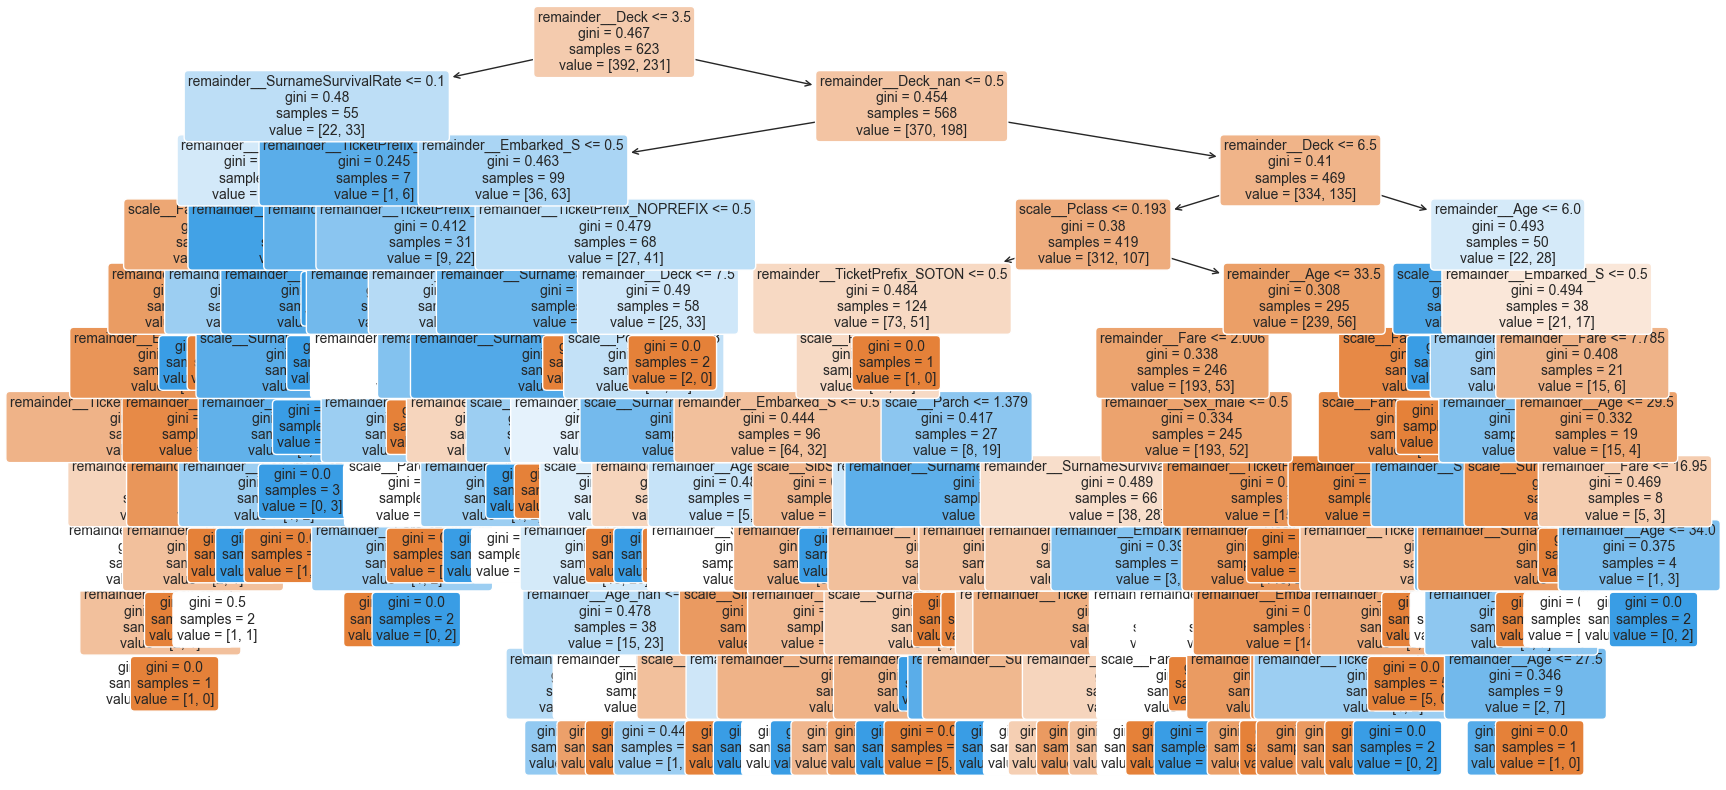

In [917]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(decision_tree=best_dt['model'], feature_names=columns, filled=True, rounded=True, fontsize=10)
plt.show()

'Embarked_S' is the most important variable, followed by 'Sex' and 'SurnameSurvivalRate'.

Now let's try some ensemble models. A random forest is an ensemble method that creates a 'forest' of decision trees. Each tree is trained on a subset of the data and gives a prediction. The random forest aggregates these predictions to produce a final result. Random forests use bootstrap aggregating (or bagging) to sub-sample the data used to train each tree, introducing randomness. Features for splitting nodes are also selected from a random subset of the available features. As with decision trees, the stopping criteria can be tuned to improve the model's performance.

In [918]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define the RandomForest pipeline with preprocessing
rfc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=seed))
])

# Define the hyperparameters and their possible values
param_distributions = {
    'model__n_estimators': randint(5, 500),
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': list(range(1, len(columns))),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 20),
    'model__bootstrap': [True, False],
    'model__criterion': ['gini', 'entropy']
}

# Use RandomizedSearchCV to search for the best hyperparameters
rfc_search = RandomizedSearchCV(
        estimator=rfc_pipeline,
        param_distributions=param_distributions,
        scoring=custom_scorer,
        cv=5,
        n_iter=100,
        random_state=seed,
        n_jobs=-1
    )

# Fit the model
rfc_search.fit(X=x_pretrain, y=y_pretrain)

# Get the best hyperparameters from the grid search
best_params = rfc_search.best_params_

# Get the best estimator and make predictions
best_rfc = rfc_search.best_estimator_

# Print the hyperparameters
print("Best hyperparameters:\n", best_params)

Best hyperparameters:
 {'model__bootstrap': False, 'model__criterion': 'entropy', 'model__max_depth': 15, 'model__max_features': 'log2', 'model__min_samples_leaf': 11, 'model__min_samples_split': 6, 'model__n_estimators': 485}


There's unfortunately quite a long training time for this model because we have so many features. Let's inspect the fitted model to see the feature importances:

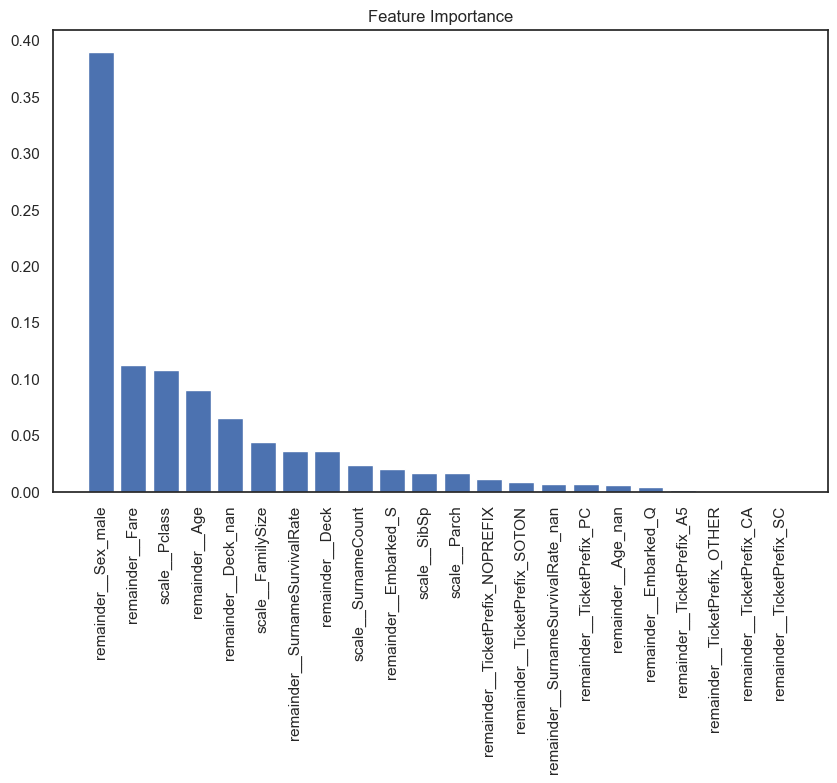

In [919]:
# Get feature importances
importances = best_rfc.named_steps['model'].feature_importances_

# Get feature names directly from the preprocessor after transformations
features = best_rfc.named_steps['preprocessor'].get_feature_names_out()

# Sort feature importances in descending order
indices = np.argsort(a=importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.title(label="Feature Importance")
plt.bar(x=range(len(names)), height=importances[indices])

# Add feature names as x-axis labels
plt.xticks(ticks=range(len(names)), labels=names, rotation=90)

# Display the plot
plt.show()

'Sex' is the most important variable, followed by 'Fare', 'Pclass', and 'Age'.

Let's see if an Extra Trees model can help us mitigate overfitting. The Extra Trees Regressor model, also known as Extremely Randomized Trees, is similar to a Random Forest model, but it uses a random threshold for each feature rather than finding the best possible threshold. This results in a higher variance for the predictions, but a lower bias, which can improve the model's performance.

In [920]:
from sklearn.ensemble import ExtraTreesClassifier

# Define the pipeline incorporating the preprocessor and the classifier
etc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ExtraTreesClassifier(random_state=seed))
])

# Adjust the parameter distributions to account for the pipeline
param_distributions = {
    'model__n_estimators': randint(5, 500),
    'model__max_features': ['log2', 'sqrt'],
    'model__criterion': ['entropy', 'gini'],
    'model__max_depth': list(range(1, len(columns))),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 20)
}

# Run the randomized search
etc_search = RandomizedSearchCV(
    estimator=etc_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=custom_scorer,
    cv=5,
    random_state=seed,
    n_jobs=-1
)

# Fit the model to the unprocessed data directly
etc_search.fit(X=x_pretrain, y=y_pretrain)

# Get the best hyperparameters from the search
best_params = etc_search.best_params_

# Set the clf to the best combination of parameters
best_etc = etc_search.best_estimator_

# Print the hyperparameters
print("Best hyperparameters:\n", best_params)

Best hyperparameters:
 {'model__criterion': 'gini', 'model__max_depth': 16, 'model__max_features': 'log2', 'model__min_samples_leaf': 4, 'model__min_samples_split': 4, 'model__n_estimators': 196}


Let's inspect this model.

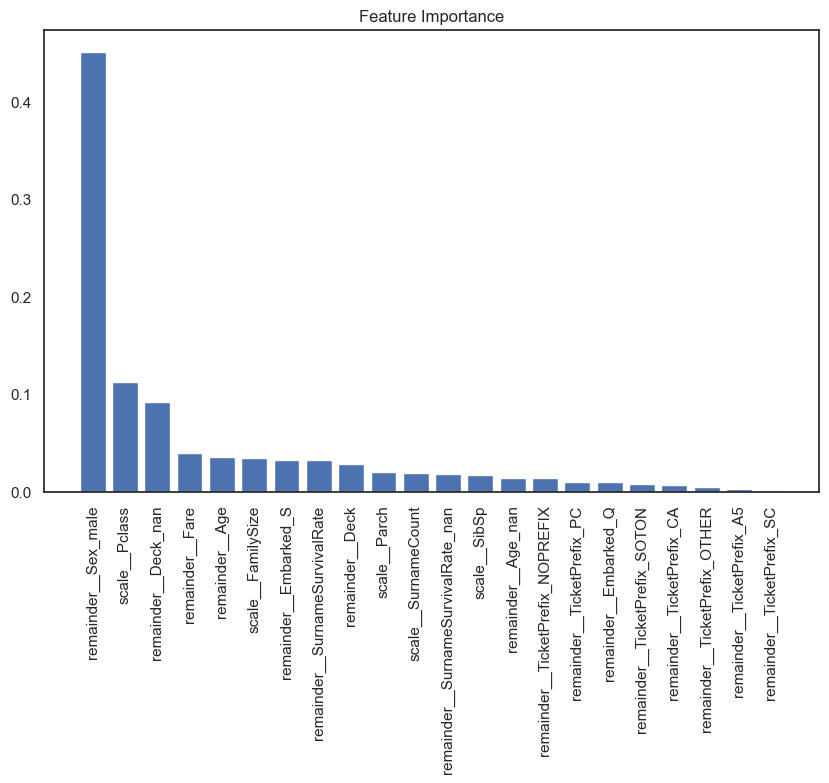

In [921]:
# Get feature importances
importances = best_etc.named_steps['model'].feature_importances_

# Get feature names directly from the preprocessor after transformations
features = best_etc.named_steps['preprocessor'].get_feature_names_out()

# Ensure that the number of features matches
assert len(features) == len(importances), "Mismatch between number of features and importances"

# Sort feature importances in descending order
indices = np.argsort(a=importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.title(label="Feature Importance")
plt.bar(x=range(len(names)), height=importances[indices])

# Add feature names as x-axis labels
plt.xticks(ticks=range(len(names)), labels=names, rotation=90)

# Display the plot
plt.show()

Sex, Pclass, and Embarked_S are the most important variables.

### Gradient Boosting Models

[XGBoost](https://en.wikipedia.org/wiki/XGBoost) is an open-source gradient boosting framework. It is a supervised learning algorithm that can be used for both classification and regression tasks. It is an ensemble model that combines many weak learners (in this case, decision trees) to produce a strong learner. It uses gradient boosting to minimize a loss function when adding new models to the ensemble. The loss function is typically a measure of error, such as mean squared error for regression or cross-entropy for classification. The algorithm starts with an initial model, then iteratively adds new models to the ensemble, each time minimizing the loss function. The new models are added in a greedy manner, so that the loss function is minimized at each step. The algorithm stops when it reaches a predefined stopping criterion, such as when the number of models reaches a certain threshold, or when the loss function falls below a certain threshold.

In [922]:
import xgboost as xgb
from scipy.stats import randint, uniform

# Define the pipeline incorporating the preprocessor and the classifier
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(objective='binary:logistic', random_state=seed, use_label_encoder=False, eval_metric='logloss'))
])

# Define parameter distributions
param_distributions = {
    'model__n_estimators': randint(5, 500),
    'model__learning_rate': uniform(0.01, 0.1),
    'model__max_depth': randint(1, len(columns)),
    'model__subsample': uniform(0.1, 0.5),
    'model__colsample_bytree': uniform(0.1, 0.2)
}

# Run the randomized search
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=custom_scorer,
    cv=5,
    random_state=seed,
    n_jobs=-1
)

# Fit the model
xgb_search.fit(X=x_pretrain, y=y_pretrain)

# Get the best hyperparameters from the grid search
best_params = xgb_search.best_params_

# Fit the best algorithm to the data
best_xgb = xgb_search.best_estimator_

# Print the hyperparameters and thresholded accuracy score
print("Best hyperparameters:\n", best_params)

Best hyperparameters:
 {'model__colsample_bytree': 0.2856637125175451, 'model__learning_rate': 0.052818414831731435, 'model__max_depth': 21, 'model__n_estimators': 99, 'model__subsample': 0.5818099885446264}


This model trains much faster than either RandomForest or ExtraTrees; XGBoost is wonderfully optimized. Let's inspect the model:

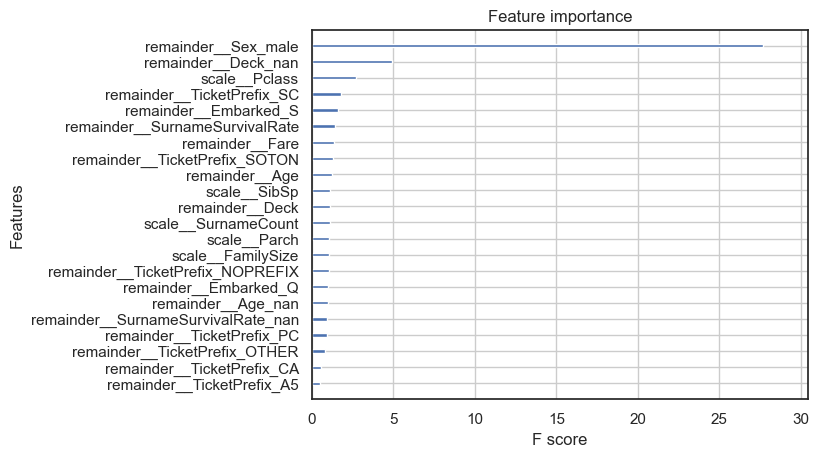

In [923]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Map 'f0', 'f1', ... to the actual feature names
mapper = {f'f{i}': feature for i, feature in enumerate(iterable=columns)}

# Plot feature importance with actual feature names
ax = plot_importance(booster=best_xgb.named_steps['model'], importance_type='gain', show_values=False)
ax.set_yticklabels([mapper.get(ylabel.get_text()) for ylabel in ax.get_yticklabels()])
plt.show()

This model makes extensive use of the titles 'Mr', 'Miss', and 'Mrs'. 'Sex', 'Deck', and 'Pclass' are also important.

Now let's perform some cross-validation scoring to select a model from the models we've trained.

## Model Selection

To avoid information leakage from the validation set (which will be used to obtain a final, unbiased estimate of model performance), we will use mean accuracy from cross-validation on the training set as our metric for model selection.

In [924]:
from sklearn.model_selection import cross_val_score

# Nested CV function
def get_nested_cv_scores(pipeline, X, y, cv=5, scoring=None):
    scores = cross_val_score(estimator=pipeline, X=X, y=y, cv=cv, scoring=scoring)
    return {"mean": scores.mean(), "std": scores.std()}

# List of models to evaluate
pipelines = {
    "Ridge Regression": ridge_pipeline,
    "Lasso Regression": lasso_pipeline,
    "Logistic Regression": logisticCV_pipeline,
    "Decision Tree": best_dt,
    "Random Forest": best_rfc,
    "Extra Trees": best_etc,
    "XGBoost": best_xgb
}

# Evaluate each model
results = {}
for name, pipeline in pipelines.items():
    if name in ["Ridge Regression", "Lasso Regression"]:
        results[name] = get_nested_cv_scores(pipeline=pipeline, X=x_pretrain, y=y_pretrain, scoring=custom_scorer)
    else:
        results[name] = get_nested_cv_scores(pipeline=pipeline, X=x_pretrain, y=y_pretrain)

# Convert results to a DataFrame
results_df = pd.DataFrame(data=results).transpose()

# Calculate mean minus std and save in new column
results_df['mean_minus_std'] = results_df['mean'] - results_df['std']

# Save best-performing model object as best_model
best_model = pipelines[results_df['mean_minus_std'].idxmax()]

# Display the results
print(results_df)

c:\Users\chris\OneDrive\Documents\Python\kaggle_notebooks\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                         mean       std  mean_minus_std
Ridge Regression     0.796116  0.068634        0.727482
Lasso Regression     0.799355  0.069302        0.730053
Logistic Regression  0.792852  0.055503        0.737349
Decision Tree        0.788103  0.027669        0.760434
Random Forest        0.829781  0.049032        0.780749
Extra Trees          0.826594  0.049639        0.776954
XGBoost              0.828245  0.047188        0.781057


To select the best-performing model, we penalize the mean performance by subtracting the standard deviation of the performance across the folds. This is because we want to select a model that performs well on average, but also one whose performance is stable across different subsets of the data. The winner is ExtraTrees, with a penalized mean accuracy of around 81% and about 4% variability in cross-validation.

## Validation

But these are cross-validation scores, which are biased estimates of model performance. To get an unbiased estimate of model performance, we need to evaluate the model on the validation set. Let's do that now.

We'll use the best-performing model, ExtraTrees, to predict the validation data. We'll then use the `accuracy_score` function to compute the accuracy of our final predictions.

In [925]:
from scipy.stats import t

# Use the best model to get cross-validation scores on the validation set 
best_validation_score = get_nested_cv_scores(pipeline=best_model, X=x_validation, y=y_validation)

# Calculate 95% confidence interval for etc_validation_scores
n = 5
t_95 = t.ppf(q=0.975, df=n-1)
margin_of_error = t_95 * (best_validation_score['std'] / np.sqrt(n))
lower_bound = best_validation_score['mean'] - margin_of_error
upper_bound = best_validation_score['mean'] + margin_of_error

print(best_validation_score)
print(f"95% Confidence Interval: ({lower_bound}, {upper_bound})")

{'mean': 0.7984626135569532, 'std': 0.032175266366115333}
95% Confidence Interval: (0.7585117436775313, 0.8384134834363752)


Our prize ExtraTrees model seemingly generalizes quite well to the out-of-sample data, scoring 82%, with a standard deviation of around 2%. It's likely we can expect a score in the range of 80–84% on our final submission.

## Final Training Phase

Let's re-train the best-performing model on the full training dataset and use it to predict the test data and submit our results to Kaggle.

In [926]:
# Fit the best algorithm to the complete training data
best_model.fit(X=x_train, y=y_train)

# Make predictions on the test set
best_prediction = best_model.predict(X=x_test).astype(dtype=int)

# Convert the predictions to a Pandas DataFrame with PassengerId and Survived columns
submission = pd.DataFrame(data={
        "PassengerId": test["PassengerId"],
        "Survived": best_prediction
    })

# Write the submission DataFrame to a CSV file
submission.to_csv(path_or_buf='submission.csv', index=False)

Our final Kaggle score of 0.77272 is somewhat below the low end of our 95% confidence interval range. This suggests either that we have some information leakage somewhere or that the test data exhibits systematic bias or distribution shift. I **think** I've guarded extremely well against leakage, so in the absence of other evidence, I'm going to chalk this up to distribution shift.

## Conclusion

77.272% is a solid score. It's likely that we could achieve an even better score by doing some more work, including:

1. More intelligently imputing the missing values, perhaps by using a linear regression or decision tree model.
2. Extracting a 'Surname' feature from 'PassengerName' and getting a 'SurnameSurvivalRate'.
3. Using an LLM or other classification model to infer ethnicities from names.
4. Doing some historical research to see if we can learn how to better interpret ticket prefixes and cabin numbers.